In [123]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

DATA_FOLDER = "data"

# Get the matches

In [2]:
# Get all matches
matches_df = pd.read_parquet(f"{DATA_FOLDER}/matches.parquet")

# Create new column with match name (team names)
matches_df["match"] = (
    matches_df["home_team"].apply(lambda x: x["short_name"])
    + " vs "
    + matches_df["away_team"].apply(lambda x: x["short_name"])
)

# Create data column with match date
matches_df["date"] = pd.to_datetime(matches_df["date_time"]).dt.date

# Sort by date
matches_df = matches_df.sort_values('date_time', ascending=True)

matches_df.tail()

# Get games from 2024-2025 season
start_date_season_24_25 = datetime.strptime("2024-08-10", "%Y-%m-%d").date()
season_24_25_matches = matches_df[matches_df["date"] > start_date_season_24_25]

# Get games from 2023-2024 season
season_23_24_matches = matches_df[matches_df["date"] < start_date_season_24_25]

# Get possession chains for a certain match
For example: the last game in the dataset:
- id: 2018396
- match: Real Madrid vs Real Sociedad
- date: 2025-05-24

For a more detailed explanation: check the [Dynamic Events CSV Specifications file](./20250314%20-%20Dynamic%20Events%20CSV%20Specifications.pdf)

In [3]:
def get_possession_chains(match_id):
    try:
        dynamic_data = pd.read_parquet(f"{DATA_FOLDER}/dynamic/{match_id}.parquet")
        
        # Only keep player_possession events
        player_possession_df = dynamic_data[dynamic_data["event_type"] == "player_possession"]

        # Relevant columns for possession chains
        pos_chain_cols = [
            "index", "match_id", "team_shortname",
            "phase_index",
            "channel_start", "channel_end", 
            "third_start", "third_end", 
            "penalty_area_start", "penalty_area_end",
            "game_interruption_after", "pass_direction_received", "pass_outcome",
            "lead_to_shot", "lead_to_goal", "possession_danger",
            "pass_ahead", "dangerous",
            "first_line_break", "second_last_line_break", "last_line_break", "furthest_line_break",
            "n_opponents_bypassed"
        ]

        return player_possession_df[pos_chain_cols]
        
    except FileNotFoundError:
        print(f"File not found for match_id: {match_id}")
        return None

pos_chain_df = get_possession_chains(2018396)
pos_chain_df.head()

,index,match_id,team_shortname,phase_index,channel_start,channel_end,third_start,third_end,penalty_area_start,penalty_area_end,...,lead_to_shot,lead_to_goal,possession_danger,pass_ahead,dangerous,first_line_break,second_last_line_break,last_line_break,furthest_line_break,n_opponents_bypassed
0,0,2018396,Real Madrid,0,center,center,middle_third,middle_third,False,False,...,False,False,None,False,None,False,False,False,None,-3.0
3,3,2018396,Real Madrid,0,center,center,middle_third,middle_third,False,False,...,False,False,None,False,None,False,False,False,None,-1.0
6,6,2018396,Real Madrid,0,half_space_left,half_space_left,middle_third,middle_third,False,False,...,False,False,None,True,None,False,False,False,None,0.0
14,14,2018396,Real Madrid,0,half_space_right,half_space_right,middle_third,middle_third,False,False,...,False,False,None,True,None,True,False,False,first,2.0
19,19,2018396,Real Madrid,0,half_space_right,half_space_right,middle_third,middle_third,False,False,...,False,False,None,False,None,False,False,False,None,-2.0


# Score parts of possession chain

In [4]:
# Possible scoring metrics:

# third_end == "attacking_third"
# penalty_area_end = True
# game_interruption_after == "corner_for", "free_kick_for", "goal_for", "penalty_for", "throw_in_for"
# pass_direction_received == "forward"
# pass_outcome == "successful"
# lead_to_shot == True
# lead_to_goal == True
# possession_danger == True
# pass_ahead == True
# dangerous == True
# first_line_break == True
# second_last_line_break == True
# last_line_break == True
# furthest_line_break == True
# n_opponents_bypassed == (int)

def score_possession_chain(chain_df):
    # Init channel scores
    channel_scores = {}

    # Loop through events of current chain
    for index, row in chain_df.iterrows():
        start_channel = row["channel_start"]
        end_channel = row["channel_end"]

        # Add 1 point to start channel
        if start_channel in channel_scores:
            channel_scores[start_channel] += 1
        else:
            channel_scores[start_channel] = 1

        # Add 1 point to end channel
        if end_channel in channel_scores:
            channel_scores[end_channel] += 1
        else:
            channel_scores[end_channel] = 1

        # Calculate total points
        total_points = sum(channel_scores.values())

        # Calculate percentages
        channel_percentages = {channel: (points / total_points) * 100 for channel, points in channel_scores.items()}

        # Calculate wing and central scores/percentages
        wing_channels = ["wide_right", "wide_left"]
        central_channels = ["center"]

        wing_score = sum(channel_scores.get(channel, 0) for channel in wing_channels)
        central_score = sum(channel_scores.get(channel, 0) for channel in central_channels)

        # Adjust scores with half space channels
        half_space_channels = ["half_space_right", "half_space_left"]
        half_space_score = sum(channel_scores.get(channel, 0) for channel in half_space_channels)
        wing_score += half_space_score / 2
        central_score += half_space_score / 2

        wing_percentage = wing_score / total_points
        central_percentage = central_score / total_points

        # Classification logic
        if wing_percentage > 0.5:
            classification = "wing"
        elif central_percentage > 0.5:
            classification = "central"
        else:
            classification = "mixed"

    return {
        'channel_scores': channel_scores,
        'channel_percentages': channel_percentages,
        'wing_score': wing_score,
        'central_score': central_score,
        'total_points': total_points,
        'wing_percentage': wing_percentage,
        'central_percentage': central_percentage,
        'classification': classification
    }

pos_chain_test = pos_chain_df[pos_chain_df["phase_index"] == 0]
score_possession_chain(pos_chain_test)

{'channel_scores': {'center': 11,
  'half_space_left': 2,
  'half_space_right': 13,
  'wide_right': 4,
  'wide_left': 2},
 'channel_percentages': {'center': 34.375,
  'half_space_left': 6.25,
  'half_space_right': 40.625,
  'wide_right': 12.5,
  'wide_left': 6.25},
 'wing_score': 13.5,
 'central_score': 18.5,
 'total_points': 32,
 'wing_percentage': 0.421875,
 'central_percentage': 0.578125,
 'classification': 'central'}

# Analyze all possession chains in a game

In [5]:
def analyze_match_chains(match_chains_df):
    madrid_chains = match_chains_df[match_chains_df["team_shortname"] == "Real Madrid"]["phase_index"].unique()
    chain_results = []

    for chain_id in madrid_chains:
        chain_df = match_chains_df[match_chains_df["phase_index"] == chain_id]
        chain_result = score_possession_chain(chain_df)

        # Chains have to be at least 3 events long
        chain_length = chain_df.shape[0]
        if chain_length < 3:
            continue

        # Add chain data to result
        chain_results.append({
            "match_id": chain_df["match_id"].iloc[0],
            "chain_id": chain_id,
            "chain_length": chain_length,
            "classification": chain_result["classification"],
            "wing_percentage": chain_result["wing_percentage"],
            "central_percentage": chain_result["central_percentage"]
        })

    return pd.DataFrame(chain_results)


chains_test_game = analyze_match_chains(pos_chain_df)
chains_test_game

,match_id,chain_id,chain_length,classification,wing_percentage,central_percentage
0,2018396,0,16,central,0.421875,0.578125
1,2018396,2,4,wing,0.562500,0.437500
2,2018396,9,4,wing,0.625000,0.375000
3,2018396,12,8,central,0.250000,0.750000
4,2018396,15,9,wing,0.611111,0.388889
...,...,...,...,...,...,...
86,2018396,298,7,wing,0.750000,0.250000
87,2018396,301,3,mixed,0.500000,0.500000
88,2018396,303,6,wing,0.708333,0.291667
89,2018396,307,3,central,0.333333,0.666667


In [6]:
mean_wing = chains_test_game['wing_percentage'].mean()
mean_central = chains_test_game['central_percentage'].mean()
print(f"\nAverage wing play: {mean_wing:.2f}%")
print(f"Average central play: {mean_central:.2f}%")


Average wing play: 0.51%
Average central play: 0.49%


In [7]:
chain_types = chains_test_game['classification'].value_counts(normalize=True)
print("Proportion of each chain type:")
print(chain_types)

Proportion of each chain type:
classification
wing       0.494505
central    0.428571
mixed      0.076923
Name: proportion, dtype: float64


# Create season timeseries

Get all possession chains for a season, group them by game and calculate the average wing and central percentage

In [153]:
def make_season_timeseries(season_matches):
    # Change match id column name for merge
    season_matches = season_matches.rename(columns={'id': 'match_id'})

    # Init empty dataframe to store chains
    season_chains = pd.DataFrame()

    for index, row in season_matches.iterrows():
        # Get possession chains for this match
        pos_chains_df = get_possession_chains(row['match_id'])

        # Skip if no data was found
        if pos_chains_df is None:
            continue

        # Analyze possession chains for this match
        match_chains_df = analyze_match_chains(pos_chains_df)
        
        # Add match chains to season chains
        season_chains = pd.concat([season_chains, match_chains_df])

    # Group by match_id and get the mean of the chains wing_percentage and central_percentage
    season_ts = season_chains.groupby('match_id').agg({
        'wing_percentage': 'mean',
        'central_percentage': 'mean'
    }).reset_index()

    # Merge with matches_df to link the data with the correct dates
    season_ts = season_ts.merge(
        season_matches[['match_id', 'date']], 
        on='match_id', 
        how='left'
    )

    # Create DatetimeIndex and set it as the index
    season_ts.index = pd.DatetimeIndex(season_ts['date'])
    
    # Sort by index
    season_ts = season_ts.sort_index()
    
    # Drop the date column since it's now the index
    season_ts = season_ts.drop('date', axis=1)

    # Add game number column (used in linear regression models)
    season_ts["game_number"] = np.arange(len(season_ts))

    return season_ts

In [154]:
season_ts_23_24 = make_season_timeseries(season_23_24_matches)
season_ts_23_24.info()

File not found for match_id: 1274919
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50 entries, 2023-08-12 to 2024-06-01
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   match_id            50 non-null     int64  
 1   wing_percentage     50 non-null     float64
 2   central_percentage  50 non-null     float64
 3   game_number         50 non-null     int64  
dtypes: float64(2), int64(2)
memory usage: 2.0 KB


In [155]:
season_ts_24_25 = make_season_timeseries(season_24_25_matches)
season_ts_24_25.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52 entries, 2024-08-18 to 2025-05-24
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   match_id            52 non-null     int64  
 1   wing_percentage     52 non-null     float64
 2   central_percentage  52 non-null     float64
 3   game_number         52 non-null     int64  
dtypes: float64(2), int64(2)
memory usage: 2.0 KB


# Calculate wingplay trend over a season

In [156]:
def create_lr_model(season_ts, trend_col):
    """ 
    Create a linear regression model to calculate the trend per game

    Parameters:
    season_ts: season time series
    trend_col: column to calculate the trend for

    Returns:
    model: linear regression model
    """


    # Copy df and reset index (best practice to copy before making changes and reset index makes it easier to add new columns)
    df = season_ts.copy().reset_index()

    # Prepare data for model
    X = df[["game_number"]] # 2D array
    y = df[trend_col]

    # Fit model
    model = LinearRegression()
    model.fit(X, y)

    return model


def calculate_trend(trend, n_games):
    """ 
    Calculate the total change over the season in percentage

    Parameters:
    trend: trend per game (slope of the linear regression model)
    n_games: number of games in the season

    Returns:
    total_change: total change over the season in percentage
    """


    total_change = trend * n_games

    return total_change * 100

In [157]:
# Calculate trend for wing play in 23/24 season
model_wing_23_24 = create_lr_model(season_ts_23_24, "wing_percentage")
trend_wing_23_24 = calculate_trend(model_wing_23_24.coef_[0], len(season_ts_23_24))
print(f"Wing trend 23/24: {trend_wing_23_24:.2f}%")

# Calculate trend for central play in 23/24 season
model_central_23_24 = create_lr_model(season_ts_23_24, "central_percentage")
trend_central_23_24 = calculate_trend(model_central_23_24.coef_[0], len(season_ts_23_24))
print(f"Central trend 23/24: {trend_central_23_24:.2f}%")

# Calculate trend for wing play in 24/25 season
model_wing_24_25 = create_lr_model(season_ts_24_25, "wing_percentage")
trend_wing_24_25 = calculate_trend(model_wing_24_25.coef_[0], len(season_ts_24_25))
print(f"Wing trend 24/25: {trend_wing_24_25:.2f}%")

# Calculate trend for central play in 24/25 season
model_central_24_25 = create_lr_model(season_ts_24_25, "central_percentage")
trend_central_24_25 = calculate_trend(model_central_24_25.coef_[0], len(season_ts_24_25))
print(f"Central trend 24/25: {trend_central_24_25:.2f}%")

Wing trend 23/24: 0.54%
Central trend 23/24: -0.54%
Wing trend 24/25: 1.88%
Central trend 24/25: -1.88%


# Plot the two seasons

Trendline for Trend Wing 23/24: slope=0.000017, angle=0.000970 degrees
Trendline for Trend Central 23/24: slope=-0.000017, angle=-0.000970 degrees
Trendline for Trend Wing 24/25: slope=0.000063, angle=0.003596 degrees
Trendline for Trend Central 24/25: slope=-0.000063, angle=-0.003596 degrees


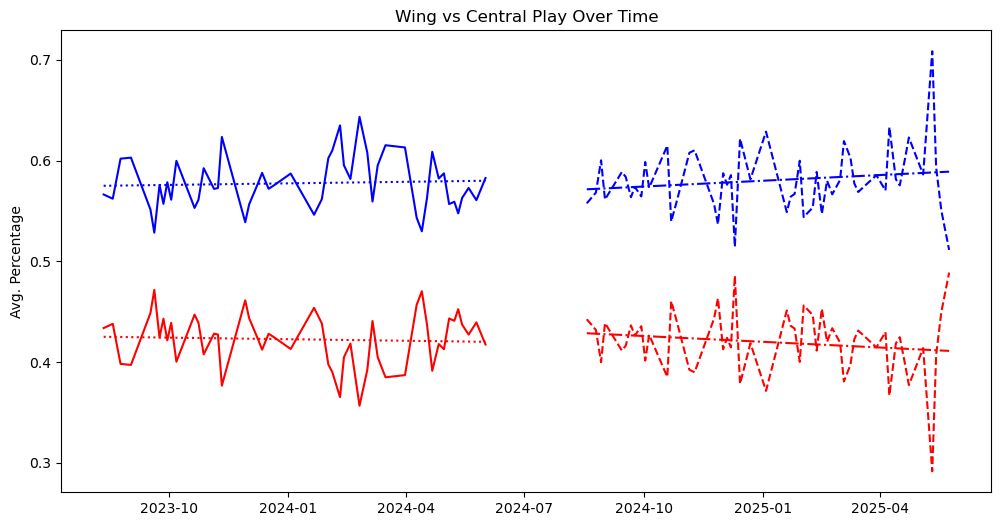

In [14]:
def add_trendline(df, col, color, linestyle, label):
    # Convert dates to ordinal for fitting
    x = df.index.map(lambda d: d.toordinal()).values.reshape(-1, 1)
    y = df[col].values
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    plt.plot(df.index, y_pred, color=color, linestyle=linestyle, label=label)
    # Calculate and print the angle in degrees
    slope = model.coef_[0]
    angle_rad = np.arctan(slope)
    angle_deg = np.degrees(angle_rad)
    print(f"Trendline for {label}: slope={slope:.6f}, angle={angle_deg:.6f} degrees")

plt.figure(figsize=(12, 6))

# Original lines
plt.plot(season_ts_23_24.index, season_ts_23_24['wing_percentage'], color='blue', label='Wing Play 23/24')
plt.plot(season_ts_23_24.index, season_ts_23_24['central_percentage'], color='red', label='Central Play 23/24')
plt.plot(season_ts_24_25.index, season_ts_24_25['wing_percentage'], color='blue', linestyle='--', label='Wing Play 24/25')
plt.plot(season_ts_24_25.index, season_ts_24_25['central_percentage'], color='red', linestyle='--', label='Central Play 24/25')

# Trendlines with angle printout (using LinearRegression)
add_trendline(season_ts_23_24, 'wing_percentage', 'blue', ':', 'Trend Wing 23/24')
add_trendline(season_ts_23_24, 'central_percentage', 'red', ':', 'Trend Central 23/24')
add_trendline(season_ts_24_25, 'wing_percentage', 'blue', '-.', 'Trend Wing 24/25')
add_trendline(season_ts_24_25, 'central_percentage', 'red', '-.', 'Trend Central 24/25')

# Set y-axis limits to 0-1
#plt.ylim(0, 1)

plt.xlabel('')
plt.ylabel('Avg. Percentage')
plt.title('Wing vs Central Play Over Time')
plt.show()

In [12]:
season_ts_24_25.tail()

,match_id,wing_percentage,central_percentage
date,,,
2025-05-04,2014987,0.586138,0.413862
2025-05-11,2016604,0.708385,0.291615
2025-05-14,2017232,0.593118,0.406882
2025-05-18,2017683,0.550338,0.449662
2025-05-24,2018396,0.511215,0.488785


# Clean up graph

In [59]:
# Colors
background_color = "#f2f4ee"
dark_color = "#0F2145"
primary_color = "#00529F"
secondary_color = "#EE324E"

# Font
font = 'Futura'

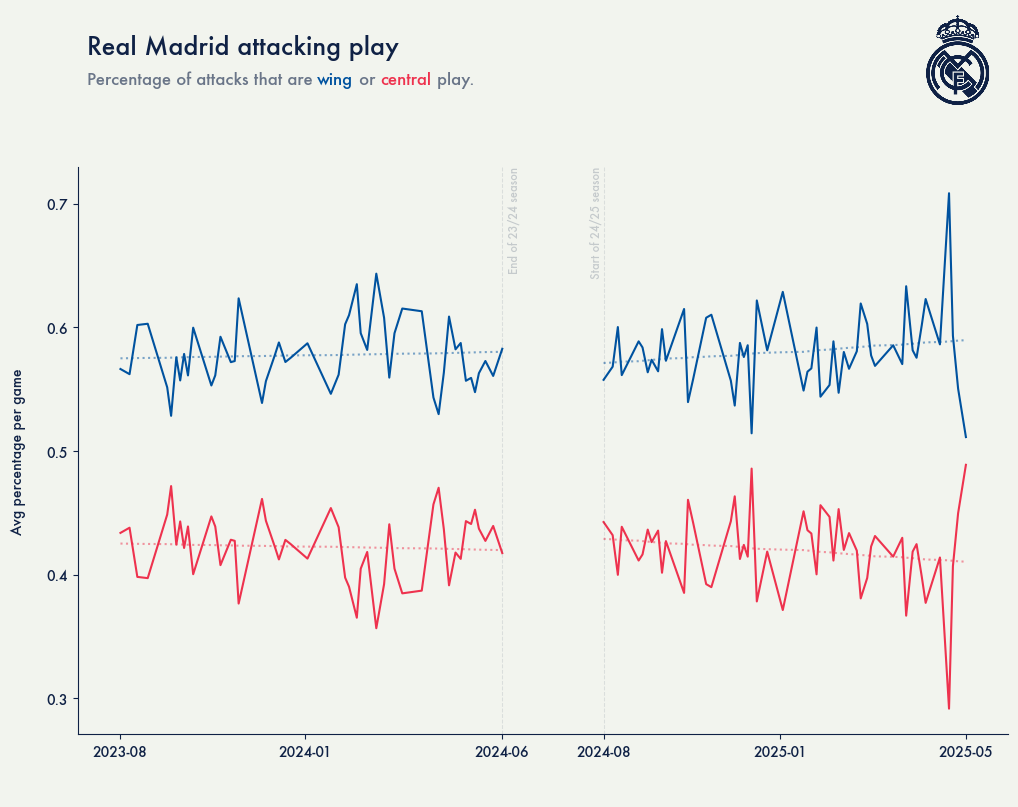

In [ ]:
# Init plot
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[0.1, 0.9])

fig.set_facecolor(background_color)

# Top axis for title and logo
title_ax = fig.add_subplot(gs[0])
title_ax.axis('off')

# Main plot axis
ax = fig.add_subplot(gs[1])
ax.set_facecolor(background_color)

plt.rcParams['font.family'] = font
plt.rcParams.update({
    'text.color': dark_color,
    'axes.labelcolor': dark_color,
    'axes.edgecolor': dark_color,
    'xtick.color': dark_color,
    'ytick.color': dark_color,
    'grid.color': dark_color,
})

# Set axis labels
ax.set_xlabel(' ', labelpad=15)
ax.set_ylabel('Avg percentage per game', labelpad=15)

# Set x-axis tick dates
tick_dates = [
    season_ts_23_24.index[0],
    datetime(2024, 1, 1),
    season_ts_23_24.index[-1],
    season_ts_24_25.index[0],
    datetime(2025, 1, 1),
    season_ts_24_25.index[-1]
]

# Set x-axis tick dates
ax.set_xticks(tick_dates)
ax.set_xticklabels([d.strftime('%Y-%m') for d in tick_dates])

# Starting coordinates for titles
x0 = 0.01
y0 = 0.4
fontsize = 12
alpha = 0.6


# Title and subtitle in title_ax
title_ax.text(x0, y0 + 0.5, 'Real Madrid attacking play', fontweight='bold', fontsize=18, ha='left', va='center')
title_ax.text(x0, y0, 'Percentage of attacks that are ', fontsize=fontsize, alpha=alpha, ha='left', va='center', color=dark_color)
title_ax.text(x0 + 0.247, y0 - 0.01, 'wing', fontsize=fontsize, ha='left', va='center', color=primary_color)
title_ax.text(x0 + 0.287, y0 - 0.01, ' or ', fontsize=fontsize, alpha=alpha, ha='left', va='center', color=dark_color)
title_ax.text(x0 + 0.315, y0 - 0.01, 'central', fontsize=fontsize, ha='left', va='center', color=secondary_color)
title_ax.text(x0 + 0.37, y0 - 0.01, ' play.', fontsize=fontsize, alpha=alpha, ha='left', va='center', color=dark_color)

# Add PL logo to title_ax
logo = mpimg.imread('rm-logo.png')
imagebox = OffsetImage(logo, zoom=0.2)
ab = AnnotationBbox(imagebox, (0.98, 0.7), xycoords='axes fraction', box_alignment=(1, 0.5), frameon=False)
title_ax.add_artist(ab)

# Plot percentage lines
ax.plot(season_ts_23_24.index, season_ts_23_24['wing_percentage'], color=primary_color)
ax.plot(season_ts_23_24.index, season_ts_23_24['central_percentage'], color=secondary_color)
ax.plot(season_ts_24_25.index, season_ts_24_25['wing_percentage'], color=primary_color)
ax.plot(season_ts_24_25.index, season_ts_24_25['central_percentage'], color=secondary_color)

# Plot trendlines with model
def plot_trendline(df, model, color, linestyle):
    x = df[['game_number']]
    y_pred = model.predict(x)
    plt.plot(df.index, y_pred, color=color, linestyle=linestyle, alpha=0.5)

plot_trendline(season_ts_23_24, model_wing_23_24, primary_color, ':')
plot_trendline(season_ts_24_25, model_wing_24_25, primary_color, ':')
plot_trendline(season_ts_23_24, model_central_23_24, secondary_color, ':')
plot_trendline(season_ts_24_25, model_central_24_25, secondary_color, ':')

# Add vertical lines on end of season 23-24 and start of season 24-25   
ax.axvline(x=season_ts_23_24.index[-1], color=dark_color, linestyle='--', linewidth=.75, alpha=0.1)
ax.axvline(x=season_ts_24_25.index[0], color=dark_color, linestyle='--', linewidth=.75, alpha=0.1)

# Add text to vertical lines
end_23_24 = season_ts_23_24.index[-1] + timedelta(days=4)
ax.text(end_23_24, 0.73, 'End of 23/24 season', color=dark_color, fontsize=8, ha='left', va='top', rotation=90, alpha=0.2)
end_24_25 = season_ts_24_25.index[0] + timedelta(days=-1)
ax.text(end_24_25, 0.73, 'Start of 24/25 season', color=dark_color, fontsize=8, ha='right', va='top', rotation=90, alpha=0.2)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout and margins
plt.savefig('wing-vs-central-play.png', 
            bbox_inches='tight',
            pad_inches=0.5,
            facecolor=background_color,
            dpi=300)

plt.show()

# Test for noticable difference